In [1]:
#Import packages
from resampling import Resampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import jensenshannon

In [2]:
dataset = pd.read_csv('output/final_predictions.csv').dropna()dataset = dataset[~dataset.location_label.isin(['Other','Brussel_Wallonie'])]
dataset['age_label_bin'] = dataset['age_label'].map({'-18':0,'20-29':1,'30-39':2,'40+':3})
dataset['gender_label_bin'] = dataset['gender_label'].map({'Female':0,'Male':4})
#We create 8 unique ids for each joint demographic category
dataset['dem'] = dataset['age_label_bin']  + dataset['gender_label_bin'] 
dataset['id'] = dataset['user_id']

In [3]:
#Load  the census and twitter population demographics
dem_data = pd.read_csv('Census_Demographics_Twitter.csv')
dem_data = dem_data[dem_data.Gender != 'Tot']
dem_data = dem_data[dem_data.Age != 'Tot']


In [4]:
dem_data['norm_Census'] = dem_data['Census'] / dem_data['Census'].sum()
dem_data['norm_Twitter'] = dem_data['Twitter'] / dem_data['Twitter'].sum()#Group the demographic data by gender and age 
agg_data = dem_data.groupby(['Gender','Age']).agg({'Census':'sum','Twitter':'sum',
'norm_Census':'sum','norm_Twitter':'sum'})

In [5]:
census = np.array(agg_data['norm_Census'])
twitter = np.array(agg_data['norm_Twitter']) 

In [6]:
#the Jensen-Shannon metric measures the divergence between two probability distribution. The lower the better in our case
print("Jensen-Shannon divergence before correction : %s"%jensenshannon(agg_data['Census'],agg_data['Twitter']))

Jensen-Shannon divergence before correction : 0.3844462214321886


The high J-S divergence value clearly indicates the presence of selection bias.

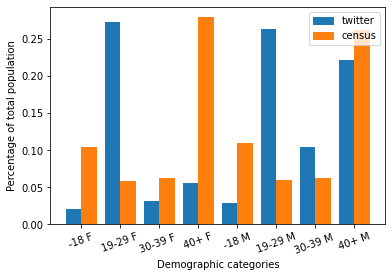

In [14]:
colors = {'twitter':'#1f77b4', 'census':'#ff7f0e'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(x= np.array([0,1,2,3,4,5,6,7])  -0.2, height = twitter, width = 0.4)
plt.bar(x =  np.array([0,1,2,3,4,5,6,7]) +0.2, height = census, width = 0.4)
plt.xticks(ticks = [0,1,2,3,4,5,6,7], labels = ['-18 F','19-29 F','30-39 F ','40+ F','-18 M','19-29 M','30-39 M ','40+ M'], rotation = 20)

plt.ylabel('Percentage of total population')
plt.xlabel('Demographic categories');

## Applying resampling 



The resampling algorithm is stochastic. We set a seed for reproducibility.

In [41]:
resampler = Resampler(seed = 42)  
resampler.fit(census,twitter)

In [42]:
sample = resampler.resample(dataset)
sample_dist = sample['dem'].value_counts(normalize = True).sort_index()

In [43]:
for i in range(8):
  if i not in sample_dist.index : #If no user from that category has been sampled, add a row with value 0 for that category
    sample_dist[i] = 0

In [44]:
print("Jensen-Shannon divergence after correction : %s"%jensenshannon(agg_data['norm_Census'],sample_dist))

Jensen-Shannon divergence after correction : 0.24448158065963516


Results improved a little with the default resampling parameters

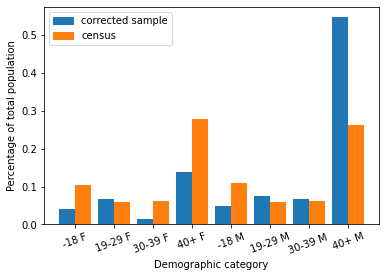

In [45]:
colors = {'corrected sample':'#1f77b4', 'census':'#ff7f0e'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(x= sample_dist.index[0:8] -0.2, height = sample_dist.values, width = 0.4)
plt.bar(x =  np.array([0,1,2,3,4,5,6,7]) +0.2, height = census, width = 0.4)
plt.xticks(ticks = [0,1,2,3,4,5,6,7], labels = ['-18 F','19-29 F','30-39 F ','40+ F','-18 M','19-29 M','30-39 M ','40+ M'], rotation =20)
plt.ylabel('Percentage of total population')
plt.xlabel('Demographic category')
plt.plot();

## Optimizing parameters N and n

We perform a small grid search to find better values for the two resampler parameters : N and n. 


In [46]:
#Grid 
param_grid = {'N':[500,1000,2000,5000,10000,15000,20000],
              'n':[5,10,20,50,100]}

min_divergence = 1
best_N = 0
best_n = 0
for i in param_grid['N']:
  for j in param_grid['n']:
    resampler = Resampler(i,j,seed = 42)
    sample = resampler.fit_resample(dataset,census, twitter)
    sample_dist = sample['dem'].value_counts(normalize = True).sort_index()
    for k in range(8):
      if k not in sample_dist.index : 
        sample_dist[k] = 0
    divergence = jensenshannon(agg_data['norm_Census'],sample_dist)
    if  divergence < min_divergence:
      min_divergence = divergence
      best_N = i
      best_n = j
print('Best params : %s,%s - JS Divergence : %s'%(best_N,best_n,min_divergence))

Best params : 20000,50 - JS Divergence : 0.07920883786418272


This is a much bigger improvement.

In [57]:
resampler = Resampler(20000,50,seed = 42)
sample = resampler.fit_resample(dataset,census,twitter)
sample_dist = sample['dem'].value_counts(normalize = True).sort_index()
print("Jensen-Shannon divergence after correction : %s"%jensenshannon(agg_data['norm_Census'],sample_dist))

Jensen-Shannon divergence after correction : 0.07920883786418272


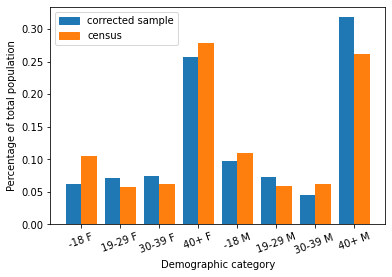

In [58]:
colors = {'corrected sample':'#1f77b4', 'census':'#ff7f0e'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]
plt.legend(handles, labels)

plt.bar(x= sample_dist.index[0:8] -0.2, height = sample_dist.values, width = 0.4)
plt.bar(x =  np.array([0,1,2,3,4,5,6,7]) +0.2, height = census, width = 0.4)
plt.xticks(ticks = [0,1,2,3,4,5,6,7], labels = ['-18 F','19-29 F','30-39 F ','40+ F','-18 M','19-29 M','30-39 M ','40+ M'], rotation =20)
plt.ylabel('Percentage of total population')
plt.xlabel('Demographic category')
plt.plot();